In [14]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Normal
from torch.distributions import Categorical
import matplotlib.pyplot as plt


In [15]:

# デバイスの設定
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# グリッドワールド環境の定義
class GridWorldEnv(gym.Env):
    def __init__(self):
        super(GridWorldEnv, self).__init__()
        self.width = 5
        self.height = 5
        self.action_space = spaces.Discrete(4)  # 上、下、左、右
        self.observation_space = spaces.Discrete(self.width * self.height)
        self.pitfalls = [(1, 1), (3, 3)]  # 落とし穴の位置
        self.goal = (4, 4)  # ゴールの位置
        self.reset()

    def reset(self):
        self.agent_pos = (0, 0)
        # return self._get_obs(), {}
        return self.agent_pos, {}

    def step(self, action):
        x, y = self.agent_pos
        if action == 0:  # 上
            y = max(0, y - 1)
        elif action == 1:  # 下
            y = min(self.height - 1, y + 1)
        elif action == 2:  # 左
            x = max(0, x - 1)
        elif action == 3:  # 右
            x = min(self.width - 1, x + 1)
        
        self.agent_pos = (x, y)
        
        done = False
        reward = -1  # 各ステップのペナルティ
        
        if self.agent_pos in self.pitfalls:
            done = True
            reward = -10
        elif self.agent_pos == self.goal:
            done = True
            reward = 10
        
        # return self._get_obs(), reward, done, False, {}
        return self.agent_pos, reward, done, False, {}

    # def _get_obs(self):
    #     return self.agent_pos[0] * self.width + self.agent_pos[1]


cuda


In [16]:

class DebugInfo:
    def __init__(self):
        self.episode_rewards = []
        self.actor_losses = []
        self.critic_losses = []
        self.q_values = []

debug_info = DebugInfo()


In [17]:

# アクターネットワークの定義
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Actor, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, action_dim)
        )

    def forward(self, state):
        return self.net(state)

    def sample(self, state):
        logits = self.forward(state)
        dist = Categorical(logits=logits)
        action = dist.sample()
        return action, dist.log_prob(action)

# クリティックネットワークの定義
class Critic(nn.Module):
    def __init__(self, state_dim):
        super(Critic, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, state):
        return self.net(state)

# SACエージェントの定義
class SAC:
    def __init__(self, state_dim, action_dim):
        self.actor = Actor(state_dim, action_dim).to(device)
        self.critic_1 = Critic(state_dim).to(device)
        self.critic_2 = Critic(state_dim).to(device)
        self.critic_target_1 = Critic(state_dim).to(device)
        self.critic_target_2 = Critic(state_dim).to(device)

        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=1e-3)
        self.critic_1_optimizer = optim.Adam(self.critic_1.parameters(), lr=1e-3)
        self.critic_2_optimizer = optim.Adam(self.critic_2.parameters(), lr=1e-3)

        self.critic_target_1.load_state_dict(self.critic_1.state_dict())
        self.critic_target_2.load_state_dict(self.critic_2.state_dict())

        self.gamma = 0.99
        self.tau = 0.005
        self.alpha = 0.2

    def select_action(self, state):
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        action, _ = self.actor.sample(state)
        return action.cpu().data.numpy().flatten()

    def train(self, replay_buffer, batch_size=64):
        state, action, next_state, reward, not_done = replay_buffer.sample(batch_size)

        with torch.no_grad():
            next_action, next_log_pi = self.actor.sample(next_state)
            target_Q1 = self.critic_target_1(next_state)
            target_Q2 = self.critic_target_2(next_state)
            target_Q = torch.min(target_Q1, target_Q2) - self.alpha * next_log_pi
            target_Q = reward + not_done * self.gamma * target_Q

        current_Q1 = self.critic_1(state)
        current_Q2 = self.critic_2(state)
        critic_loss = nn.MSELoss()(current_Q1, target_Q) + nn.MSELoss()(current_Q2, target_Q)

        self.critic_1_optimizer.zero_grad()
        self.critic_2_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_1_optimizer.step()
        self.critic_2_optimizer.step()

        action, log_pi = self.actor.sample(state)
        Q1 = self.critic_1(state)
        Q2 = self.critic_2(state)
        Q = torch.min(Q1, Q2)
        actor_loss = (self.alpha * log_pi - Q).mean()

        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        for param, target_param in zip(self.critic_1.parameters(), self.critic_target_1.parameters()):
            target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)
        for param, target_param in zip(self.critic_2.parameters(), self.critic_target_2.parameters()):
            target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

        # デバッグ情報の記録
        debug_info.critic_losses.append(critic_loss.item())
        debug_info.actor_losses.append(actor_loss.item())
        debug_info.q_values.append(Q.mean().item())

# リプレイバッファの定義
class ReplayBuffer:
    def __init__(self, state_dim, max_size=int(1e5)):
        self.max_size = max_size
        self.ptr = 0
        self.size = 0

        self.state = np.zeros((max_size, state_dim))
        self.action = np.zeros((max_size, 1))
        self.next_state = np.zeros((max_size, state_dim))
        self.reward = np.zeros((max_size, 1))
        self.not_done = np.zeros((max_size, 1))

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def add(self, state, action, next_state, reward, done):
        self.state[self.ptr] = state
        self.action[self.ptr] = action
        self.next_state[self.ptr] = next_state
        self.reward[self.ptr] = reward
        self.not_done[self.ptr] = 1. - done

        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)

    def sample(self, batch_size):
        ind = np.random.randint(0, self.size, size=batch_size)

        return (
            torch.FloatTensor(self.state[ind]).to(self.device),
            torch.LongTensor(self.action[ind]).to(self.device),
            torch.FloatTensor(self.next_state[ind]).to(self.device),
            torch.FloatTensor(self.reward[ind]).to(self.device),
            torch.FloatTensor(self.not_done[ind]).to(self.device)
        )


In [18]:
debug_info = DebugInfo()

#  トレーニングループ

def train():
    env = GridWorldEnv()
    # state_dim = env.observation_space.n
    state_dim = 2
    action_dim = env.action_space.n
    print(f"state_dim = {state_dim}, action_dim = {action_dim}")

    agent = SAC(state_dim, action_dim)
    replay_buffer = ReplayBuffer(state_dim)

    num_episodes = 100
    max_steps = 100
    batch_size = 64

    for episode in range(num_episodes):
        state, _ = env.reset()
        episode_reward = 0

        for t in range(max_steps):
            action = agent.select_action(state)
            next_state, reward, done, _, _ = env.step(int(action[0]))
            
            replay_buffer.add(state, action, next_state, reward, done)
            state = next_state
            episode_reward += reward

            if replay_buffer.size > batch_size:
                agent.train(replay_buffer, batch_size)

            if done:
                break

        debug_info.episode_rewards.append(episode_reward)
        print(f"Episode {episode+1}: Reward = {episode_reward}")

    return debug_info, agent, env


# トレーニングの実行
debug_info, agent, env = train()


state_dim = 2, action_dim = 4
Episode 1: Reward = -13
Episode 2: Reward = -17
Episode 3: Reward = -24
Episode 4: Reward = -34
Episode 5: Reward = -23
Episode 6: Reward = -7
Episode 7: Reward = -14
Episode 8: Reward = -11
Episode 9: Reward = -17
Episode 10: Reward = -11
Episode 11: Reward = -20
Episode 12: Reward = -11
Episode 13: Reward = -19
Episode 14: Reward = -19
Episode 15: Reward = -14
Episode 16: Reward = -11
Episode 17: Reward = -14
Episode 18: Reward = -7
Episode 19: Reward = -12
Episode 20: Reward = -11
Episode 21: Reward = -11
Episode 22: Reward = -18
Episode 23: Reward = -11
Episode 24: Reward = -21
Episode 25: Reward = -22
Episode 26: Reward = -11
Episode 27: Reward = -27
Episode 28: Reward = -16
Episode 29: Reward = -14
Episode 30: Reward = -35
Episode 31: Reward = -15
Episode 32: Reward = -18
Episode 33: Reward = -11
Episode 34: Reward = -17
Episode 35: Reward = -29
Episode 36: Reward = -19
Episode 37: Reward = -15
Episode 38: Reward = -32
Episode 39: Reward = -19
Episod

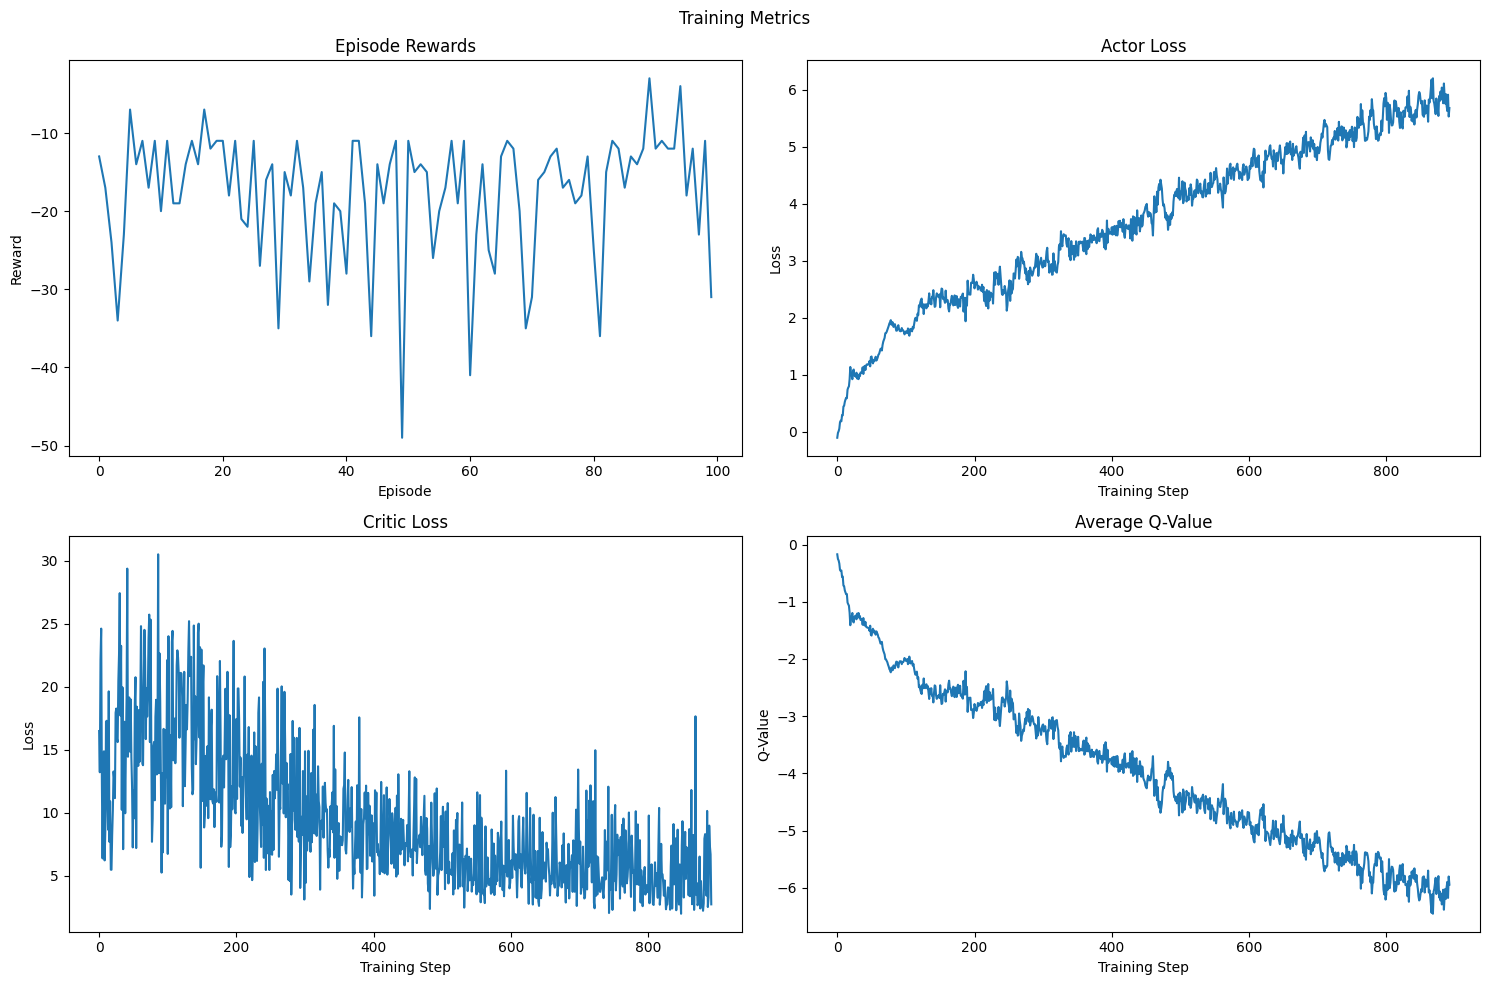

In [19]:

# デバッグ情報の可視化
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Training Metrics')

axs[0, 0].plot(debug_info.episode_rewards)
axs[0, 0].set_title('Episode Rewards')
axs[0, 0].set_xlabel('Episode')
axs[0, 0].set_ylabel('Reward')

axs[0, 1].plot(debug_info.actor_losses)
axs[0, 1].set_title('Actor Loss')
axs[0, 1].set_xlabel('Training Step')
axs[0, 1].set_ylabel('Loss')

axs[1, 0].plot(debug_info.critic_losses)
axs[1, 0].set_title('Critic Loss')
axs[1, 0].set_xlabel('Training Step')
axs[1, 0].set_ylabel('Loss')

axs[1, 1].plot(debug_info.q_values)
axs[1, 1].set_title('Average Q-Value')
axs[1, 1].set_xlabel('Training Step')
axs[1, 1].set_ylabel('Q-Value')

plt.tight_layout()
plt.show()

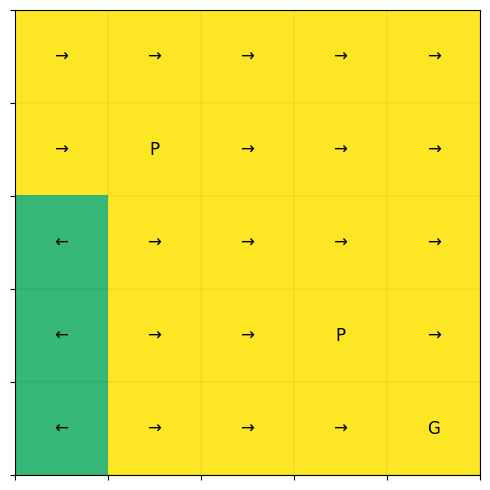

In [20]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_policy(agent, env):
    policy_matrix = np.zeros((env.height, env.width))
    for i in range(env.height):
        for j in range(env.width):
            state = i * env.width + j
            action_probs = agent.actor(torch.FloatTensor(np.array([i, j])).unsqueeze(0).to(device)).detach().cpu().numpy()
            policy_matrix[i, j] = np.argmax(action_probs)

    fig, ax = plt.subplots(figsize=(5, 5))
    ax.imshow(policy_matrix, cmap='viridis', interpolation='none', vmin=0, vmax=3)
    ax.set_xticks(np.arange(-0.5, env.width, 1))
    ax.set_yticks(np.arange(-0.5, env.height, 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.grid(which='both', color='black', linewidth=0.05)

    for i in range(env.height):
        for j in range(env.width):
            if (i, j) == env.goal:
                ax.text(j, i, 'G', ha='center', va='center', color='black', fontsize=12)
            elif (i, j) in env.pitfalls:
                ax.text(j, i, 'P', ha='center', va='center', color='black', fontsize=12)
            else:
                action = int(policy_matrix[i, j])
                arrow = ['↑', '↓', '←', '→'][action]
                ax.text(j, i, arrow, ha='center', va='center', color='black', fontsize=12)

    plt.tight_layout()
    plt.savefig('policy_visualization.png')
    plt.show()


# 方策の可視化
visualize_policy(agent, env)